In [1]:
import pypsa
import pandas as pd
import numpy as np

In [2]:
# Lifespan
lifetime_wind = 25 # Jahre
lifetime_solar = 30 # Jahre

#Preise
solar_price = 1600000/lifetime_solar # Solarkosten [€/(MW*a)]
wind_price = 700000/lifetime_wind # Windkosten [€/(MW*a)]
steel_revenue_specific = -200 # Erlöse [€/MWh]
steel_revenue_total = steel_revenue_specific * 11000000 * 2.1 # Erlöse [€/a]

elektrolysis_price = 450000 # Investitionskosten [€/MW]

electricity_storage_price = 450000 # Investitionskosten [€/MWh]
hydrogen_storage_price = 27000 # Investitionskosten [€/MWh]

# Profile
renewable_profile_solar = pd.read_csv("Gruppe_7_Simulation von Energiesystemen_pv_lastprofile.CSV", usecols=["electricity"]) # Lastprofil EE
renewable_profile_solar = renewable_profile_solar["electricity"].astype(float)
renewable_profile_wind = pd.read_csv("Gruppe_7_Simulation von Energiesystemen_wind_lastprofile.CSV", usecols=["electricity"]) # Lastprofil EE
renewable_profile_wind = renewable_profile_wind["electricity"].astype(float)

# Energiebedarf für 11 Mio Tonnen Stahl pro Jahr
leistungsbedarf_strom = 502.28 # Energiebedarf [MW] Strom 400 kWh/t Stahl
leistungsbedarf_wasserstoff = 2134.7 # Energiebedarf [MW] Wasserstoff 1700 kWh/t Stahl

# Effizienz Speicher
storage_loss_stromspeicher_month = 0.02
storage_loss_stromspeicher_hour = storage_loss_stromspeicher_month / 720
storage_loss_wasserstoffspeicher_day = 0.005
storage_loss_wasserstoffspeicher_hour = storage_loss_wasserstoffspeicher_day / 24

In [3]:
network = pypsa.Network()
network.set_snapshots(range(8760))

In [4]:
# Bus
network.add("Bus", name = "electricity")
network.add("Bus", name = "hydrogen")
network.add("Bus", name = "ee")
network.add("Bus", name = "electrical_store")
network.add("Bus", name = "hydrogen_store")

In [5]:
# Generator Wind
network.add("Generator", name = "wind_energy", bus="ee",
            p_nom_extendable=True,  # Windparkleistung soll optimiert werden
            p_max_pu=renewable_profile_wind,
            capital_cost=wind_price)
# Generator Solar
network.add("Generator", name = "solar_energy", bus="ee",
            p_nom_extendable=True,  # Solarparkleistung soll optimiert werden
            p_max_pu=renewable_profile_solar,
            capital_cost=solar_price)

In [6]:
# Link Selbstverbrauch
network.add("Link", name = "self_consumption", bus0="ee", bus1="electricity",
            p_nom= np.inf) # Nennleistung [MW]
# Link Elektrolysator
network.add("Link", name = "electrolysator", bus0="electricity", bus1="hydrogen",
            efficiency=0.65,
            p_nom_extendable=True,  # Leistung Elektrolyseur soll dimensioniert werden
            capital_cost= elektrolysis_price)  # Investitionskosten [€/MW]

# Link Aufladen Batterie
network.add("Link", name = "charge_battery", bus0="electricity", bus1="electrical_store", 
            p_nom=np.inf, efficiency=0.95) # Nennleistung [MW]
# Link Entladen Batterie
network.add("Link", name = "discharge_battery", bus0="electrical_store", bus1="electricity",
            p_nom=np.inf, efficiency=0.95) # Nennleistung [MW]
# Link Aufladen Wasserstoffspeicher
network.add("Link", name = "charge_hydrogen_storage", bus0="hydrogen", bus1="hydrogen_store", 
            p_nom=np.inf, efficiency=0.9) # Nennleistung [MW]
# Link Entladen Wasserstoffspeicher
network.add("Link", name = "discharge_hydrogen_storage", bus0="hydrogen_store", bus1="hydrogen", 
            p_nom=np.inf, efficiency=1) # Nennleistung [MW]

In [7]:
# Elektrischer Speicher
network.add("Store", name = "electricity_storage", bus= "electrical_store",
            e_nom_extendable=True,  # Kapazität Speicher soll dimensioniert werden
            capital_cost=electricity_storage_price,  # Investitionskosten [€/MWh]
            standing_loss=storage_loss_stromspeicher_hour,
            e_min_pu=0.0,
            e_cyclic=True)

# Wasserstoffspeicher
network.add("Store", name = "hydrogen_storage", bus= "hydrogen_store",
            e_nom_extendable=True,  # Kapazität Speicher soll dimensioniert werden
            capital_cost=hydrogen_storage_price,  # Investitionskosten [€/MWh]
            standing_loss=storage_loss_wasserstoffspeicher_hour,
            e_min_pu=0.0,
            e_cyclic=True)

# Load Wasserstoff [MWh]
network.add("Load", name = "hydrogen_load", bus = "hydrogen",
           p_set=leistungsbedarf_wasserstoff)

# Load Strom [MWh]
network.add("Load", name = "electricity_load", bus = "electricity",
           p_set=leistungsbedarf_strom)

In [8]:
network.optimize(solver_name = 'gurobi', threads=1, method=1)

Index(['electricity', 'hydrogen', 'ee', 'electrical_store', 'hydrogen_store'], dtype='object', name='Bus')
Index(['electricity_storage', 'hydrogen_storage'], dtype='object', name='Store')
Index(['self_consumption', 'electrolysator', 'charge_battery',
       'discharge_battery', 'charge_hydrogen_storage',
       'discharge_hydrogen_storage'],
      dtype='object', name='Link')
Index(['electricity', 'hydrogen', 'ee', 'electrical_store', 'hydrogen_store'], dtype='object', name='Bus')
Index(['electricity_storage', 'hydrogen_storage'], dtype='object', name='Store')
Index(['self_consumption', 'electrolysator', 'charge_battery',
       'discharge_battery', 'charge_hydrogen_storage',
       'discharge_hydrogen_storage'],
      dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 1


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 17.40it/s]
INFO:linopy.io: Writing time: 3.0s


Read LP format model from file /tmp/linopy-problem-1mk6i4n2.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-1mk6i4n2.lp


Reading time = 0.87 seconds


INFO:gurobipy:Reading time = 0.87 seconds


obj: 236525 rows, 105125 columns, 407316 nonzeros


INFO:gurobipy:obj: 236525 rows, 105125 columns, 407316 nonzeros


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


INFO:gurobipy:Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Optimize a model with 236525 rows, 105125 columns and 407316 nonzeros


INFO:gurobipy:Optimize a model with 236525 rows, 105125 columns and 407316 nonzeros


Model fingerprint: 0x0693931b


INFO:gurobipy:Model fingerprint: 0x0693931b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [3e+04, 4e+05]


INFO:gurobipy:  Objective range  [3e+04, 4e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 1e+100]


INFO:gurobipy:  RHS range        [5e+02, 1e+100]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 162094 rows and 30689 columns


INFO:gurobipy:Presolve removed 162094 rows and 30689 columns


Presolve time: 0.62s


INFO:gurobipy:Presolve time: 0.62s


Presolved: 74431 rows, 74436 columns, 214533 nonzeros


INFO:gurobipy:Presolved: 74431 rows, 74436 columns, 214533 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    0.0000000e+00   3.992992e+07   0.000000e+00      1s


INFO:gurobipy:       0    0.0000000e+00   3.992992e+07   0.000000e+00      1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.03125


   51193    3.6659427e+09   3.303688e+09   0.000000e+00      5s


INFO:gurobipy:   51193    3.6659427e+09   3.303688e+09   0.000000e+00      5s


   61386    4.4823000e+09   2.010963e+09   0.000000e+00     10s


INFO:gurobipy:   61386    4.4823000e+09   2.010963e+09   0.000000e+00     10s


   66597    4.5770987e+09   6.371706e+06   0.000000e+00     15s


INFO:gurobipy:   66597    4.5770987e+09   6.371706e+06   0.000000e+00     15s


   70566    4.6043123e+09   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:   70566    4.6043123e+09   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 70566 iterations and 19.92 seconds (12.59 work units)


INFO:gurobipy:Solved in 70566 iterations and 19.92 seconds (12.59 work units)


Optimal objective  4.604312325e+09


INFO:gurobipy:Optimal objective  4.604312325e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105125 primals, 236525 duals
Objective: 4.60e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [9]:
# optimieren
solar_power_opt = network.generators.loc["solar_energy", "p_nom_opt"]
wind_power_opt = network.generators.loc["wind_energy", "p_nom_opt"]
electrolyzer_power_opt = network.links.loc["electrolysator", "p_nom_opt"]
electricity_storage_capacity_opt = network.stores.loc["electricity_storage", "e_nom_opt"]
hydrogen_storage_capacity_opt = network.stores.loc["hydrogen_storage", "e_nom_opt"]

# Ausgabe
print(f"Optimale Leistung der Solaranlage: {solar_power_opt} MW")
print(f"Optimale Leistung der Windkraftanlage: {wind_power_opt} MW")
print(f"Optimale Leistung des Elektrolyseurs: {electrolyzer_power_opt} MW")
print(f"Optimale Kapazität des elektrischen Speichers: {electricity_storage_capacity_opt} MWh")
print(f"Optimale Kapazität des Wasserstoffspeichers: {hydrogen_storage_capacity_opt} MWh")

Optimale Leistung der Solaranlage: 4490.001302971463 MW
Optimale Leistung der Windkraftanlage: 52589.35897435897 MW
Optimale Leistung des Elektrolyseurs: 3515.891770823919 MW
Optimale Kapazität des elektrischen Speichers: 282.44226769866674 MWh
Optimale Kapazität des Wasserstoffspeichers: 43818.267426187704 MWh


Gesamt installierte Stromleistung: 57079.36 MW
Durchgehende Stahlproduktionsleistung: 2636.98 MW
Elektrolysator Leistung: 3515.89 MW


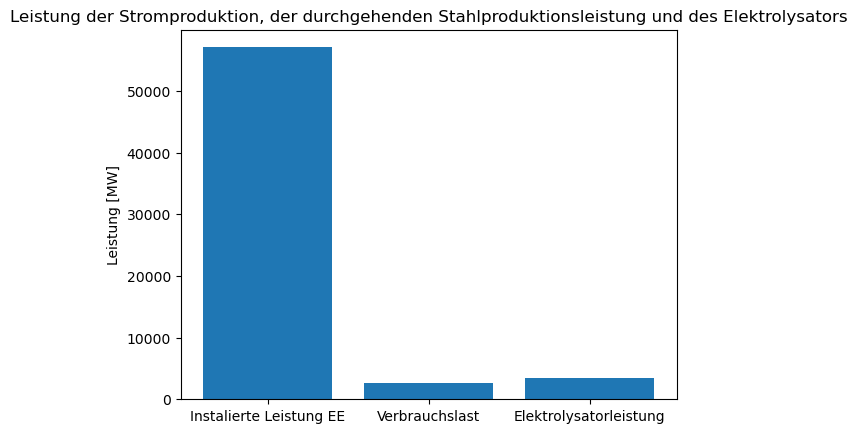

Optimale Kapazität des elektrischen Speichers: 282.44 MWh
Optimale Kapazität des Wasserstoffspeichers: 43818.27 MWh


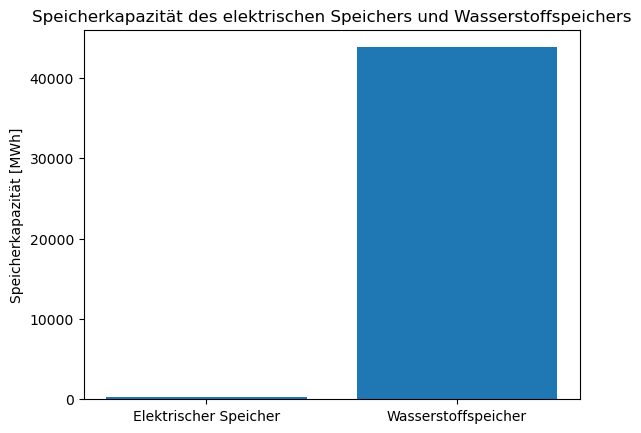

In [10]:
total_power_generator = solar_power_opt + wind_power_opt
average_power_usage = leistungsbedarf_strom + leistungsbedarf_wasserstoff

print(f"Gesamt installierte Stromleistung: {total_power_generator:.2f} MW")
print(f"Durchgehende Stahlproduktionsleistung: {average_power_usage:.2f} MW")
print(f"Elektrolysator Leistung: {electrolyzer_power_opt:.2f} MW")

# Barplot für die Darstellung der Leistung
labels_power = ["Instalierte Leistung EE", "Verbrauchslast", "Elektrolysatorleistung"]
power = [
    total_power_generator,
    average_power_usage,
    electrolyzer_power_opt,
]

# Barplot für die Darstellung der Kapazität
labels_capacity = ["Elektrischer Speicher", "Wasserstoffspeicher"]
capacity = [
    electricity_storage_capacity_opt,
    hydrogen_storage_capacity_opt,
]


import matplotlib.pyplot as plt

# Erstellung Barplot
x_1 = range(len(labels_power))
plt.bar(x_1, power)
plt.xticks(x_1, labels_power)
plt.ylabel("Leistung [MW]")
plt.title("Leistung der Stromproduktion, der durchgehenden Stahlproduktionsleistung und des Elektrolysators")
plt.show()


print(f"Optimale Kapazität des elektrischen Speichers: {electricity_storage_capacity_opt:.2f} MWh")
print(f"Optimale Kapazität des Wasserstoffspeichers: {hydrogen_storage_capacity_opt:.2f} MWh")

x_3 = range(len(labels_capacity))
plt.bar(x_3, capacity)
plt.xticks(x_3, labels_capacity)
plt.ylabel("Speicherkapazität [MWh]")
plt.title("Speicherkapazität des elektrischen Speichers und Wasserstoffspeichers")
plt.show()

<Axes: xlabel='snapshot'>

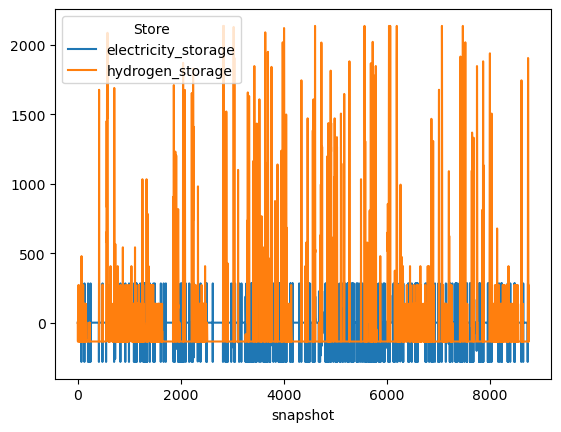

In [11]:
network.stores_t.p.plot()

Investitionskosten Solar: 7184.00 mio €
Investitionskosten Wind: 36812.55 mio €
Investitionskosten Elektrolyseur: 1582.15 mio €
Investitionskosten Stromspeicher: 127.10 mio €
Investitionskosten Wasserstoffspeicher: 1183.09 mio €
Gesamtkosten: 46888.90 mio €


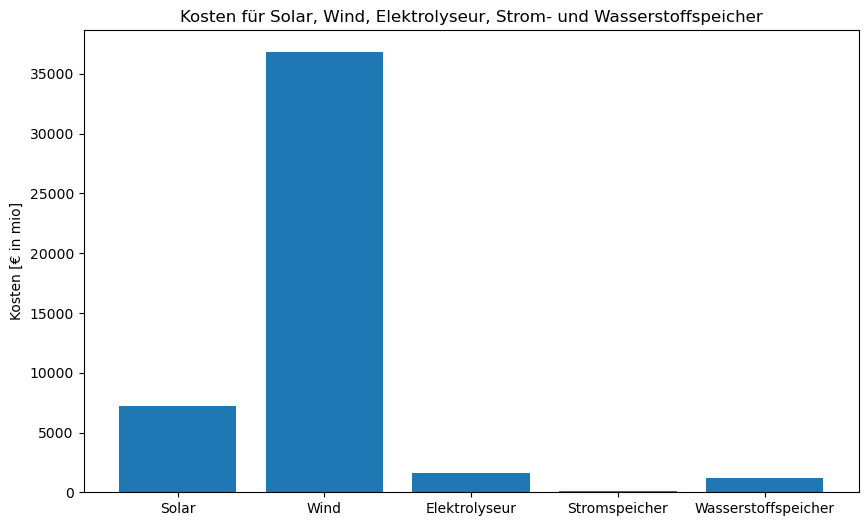

In [12]:

# Investitionskosten EE
solar_investment_cost = solar_power_opt * solar_price * lifetime_solar / 1000000 # Kosten in mio €
wind_investment_cost = wind_power_opt * wind_price * lifetime_wind / 1000000 # Kosten in mio €

# Investitionskosten Elektrolysator
electrolyzer_investment_cost = electrolyzer_power_opt * elektrolysis_price / 1000000 # Kosten in mio €

# Investitionskosten Stromspeicher
electricity_storage_investment_cost = electricity_storage_capacity_opt * electricity_storage_price / 1000000 # Kosten in mio €

# Investitionskosten Wasserstoffspeicher
hydrogen_storage_investment_cost = hydrogen_storage_capacity_opt * hydrogen_storage_price / 1000000 # Kosten in mio €

# Investitionskosten gesamt
total_investment_costs = solar_investment_cost + wind_investment_cost + electrolyzer_investment_cost + electricity_storage_investment_cost + hydrogen_storage_investment_cost

# Ausgabe der Kosten
print(f"Investitionskosten Solar: {solar_investment_cost:.2f} mio €")
print(f"Investitionskosten Wind: {wind_investment_cost:.2f} mio €")
print(f"Investitionskosten Elektrolyseur: {electrolyzer_investment_cost:.2f} mio €")
print(f"Investitionskosten Stromspeicher: {electricity_storage_investment_cost:.2f} mio €")
print(f"Investitionskosten Wasserstoffspeicher: {hydrogen_storage_investment_cost:.2f} mio €")
print(f"Gesamtkosten: {total_investment_costs:.2f} mio €")

# Barplot für die Darstellung der Kosten
labels_cost = ["Solar", "Wind", "Elektrolyseur", "Stromspeicher", "Wasserstoffspeicher"]
investment_costs = [
    solar_investment_cost,
    wind_investment_cost,
    electrolyzer_investment_cost,
    electricity_storage_investment_cost,
    hydrogen_storage_investment_cost
]

# Erstellung Barplot
plt.figure(figsize=(10, 6))
x_2 = range(len(labels_cost))
plt.bar(x_2, investment_costs)
plt.xticks(x_2, labels_cost)
plt.ylabel("Kosten [€ in mio]")
plt.title("Kosten für Solar, Wind, Elektrolyseur, Strom- und Wasserstoffspeicher")
plt.show()